In [2]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256
print(torch.__version__)
print(torch.version.cuda)

def download_image(url):
    # resp = requests.get(url)
    # resp.raise_for_status()
    # return PIL.Image.open(io.BytesIO(resp.content))
    return PIL.Image.open("/hy-tmp/1000x-1.jpg")

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

1.8.0
11.1


/usr/local/miniconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cuda:0')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("/hy-tmp/vae/encoder.pkl", dev)
dec = load_model("/hy-tmp/vae/decoder.pkl", dev)

In [4]:
enc.blocks[-1].conv

Conv2d(n_in=2048, n_out=8192, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)

In [7]:
enc.blocks.output

Sequential(
  (relu): ReLU()
  (conv): Conv2d(n_in=2048, n_out=8192, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)
)

In [17]:
params = enc.state_dict()

In [16]:
weight = params["blocks.output.conv.w"]
bias = params["blocks.output.conv.b"]

In [21]:
weight.size()  # 提取出的visual codebook的参数

torch.Size([8192, 2048, 1, 1])

In [22]:
bias.size()

torch.Size([8192])

/usr/local/miniconda3/envs/test/lib/python3.8/site-packages/torchvision/transforms/functional.py:364: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


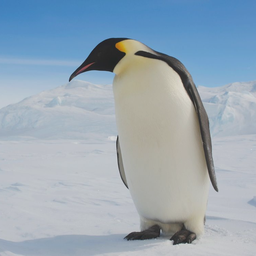

In [4]:
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg')).to(dev)
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

In [5]:
import torch.nn.functional as F
z_logits = enc(x)

In [12]:
z_logits.size()

torch.Size([1, 8192, 32, 32])

In [13]:
z = torch.argmax(z_logits, axis=1)

In [14]:
z

tensor([[[7522,  741, 6470,  ...,  629, 3844, 4695],
         [ 782, 7459, 6832,  ..., 6913, 5215, 5887],
         [1580, 4066, 5768,  ..., 5677, 2781, 2913],
         ...,
         [6694, 7130, 5047,  ..., 6027, 5770, 5538],
         [4898, 5659,  732,  ..., 3833, 6476, 4461],
         [2757, 3243, 5504,  ..., 5016, 1144, 1005]]], device='cuda:0')

In [4]:
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

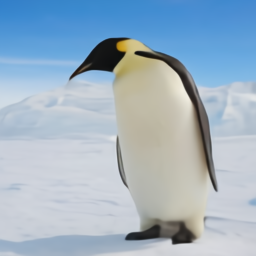

In [4]:
x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)